# 1. Dataset & Data exploration 

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import nltk
import spacy
import string
import re
import warnings

from nltk.corpus import stopwords
from nltk.collocations import *
from collections import Counter
from nltk.stem import porter
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('genesis')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
stemmer = porter.PorterStemmer()

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\98936\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\98936\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\98936\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\98936\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Importing the dataset

In [2]:
# Importing the dataset
url = 'https://raw.githubusercontent.com/shahrzadko/NLPDigitalMusic/main/Digital_Music_5.json?token=GHSAT0AAAAAAB6LOL42SKHPCCMIVYPOC4REY7AKE2Q'
df = pd.read_json(url)
full_df = pd.DataFrame.from_records(df['data'])


In [ ]:
import pandas_profiling 
report = pandas_profiling.ProfileReport(full_df)
report

In [3]:
full_df.head(5)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


## exploration 

In [4]:
full_df['overall'].describe()

count    169781.000000
mean          4.700019
std           0.713420
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [5]:
#Number of reviews
print('- Number of reviews:', len(full_df))

#Number of different products reviewed
print('- Number of different products reviewed: ', len(full_df.asin.unique()))

#Number of people who reviewed
print('- Number of people who reviewed: ', len(full_df.reviewerID.unique()))

#Reviews range and average
print('- max rating: ', full_df.overall.max())
print('- min rating: ', full_df.overall.min())
print('- avg rating: ', full_df.overall.mean())

#Time range
start = pd.to_datetime(full_df['unixReviewTime'],unit='s').min().date()
end = pd.to_datetime(full_df['unixReviewTime'],unit='s').max().date()

print('- First review: ', start)
print('- Last review: ', end)


- Number of reviews: 169781
- Number of different products reviewed:  11797
- Number of people who reviewed:  16566
- max rating:  5.0
- min rating:  1.0
- avg rating:  4.700019436803883
- First review:  1998-07-09
- Last review:  2018-09-26


Distribution of rating

Text(0, 0.5, 'reiew counts')

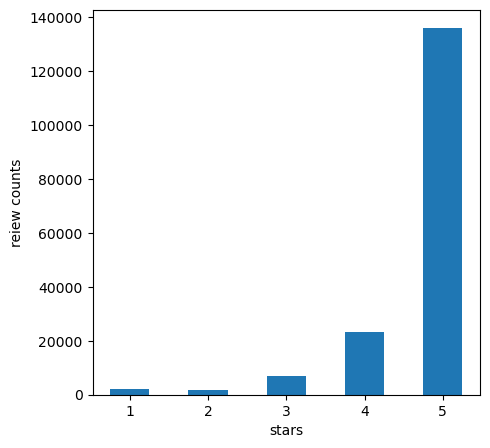

In [6]:
ax = full_df.overall.hist(grid=False, bins=np.arange(0.75,5.75,0.5),figsize=(5,5))

ax.set_xlabel("stars")
ax.set_ylabel("reiew counts")

Distribution of reviews per product

In [7]:
reviews_per_asin = full_df.asin.value_counts()
reviews_per_asin

B00CZF8B68    574
B00BWGHIHY    316
B00136J7ZE    294
B00EH49FRE    283
B00136NUG6    262
             ... 
B000W1S2WU      1
B00125MGQI      1
B001QET6G8      1
B001664ADA      1
B00138APMQ      1
Name: asin, Length: 11797, dtype: int64

reviews product-counts
5      2072
6      1506
7      1050
8       824
9       684
       ... 
146       1
147       1
148       1
152       1
574       1
Name: asin, Length: 163, dtype: int64


Text(0, 0.5, 'product counts')

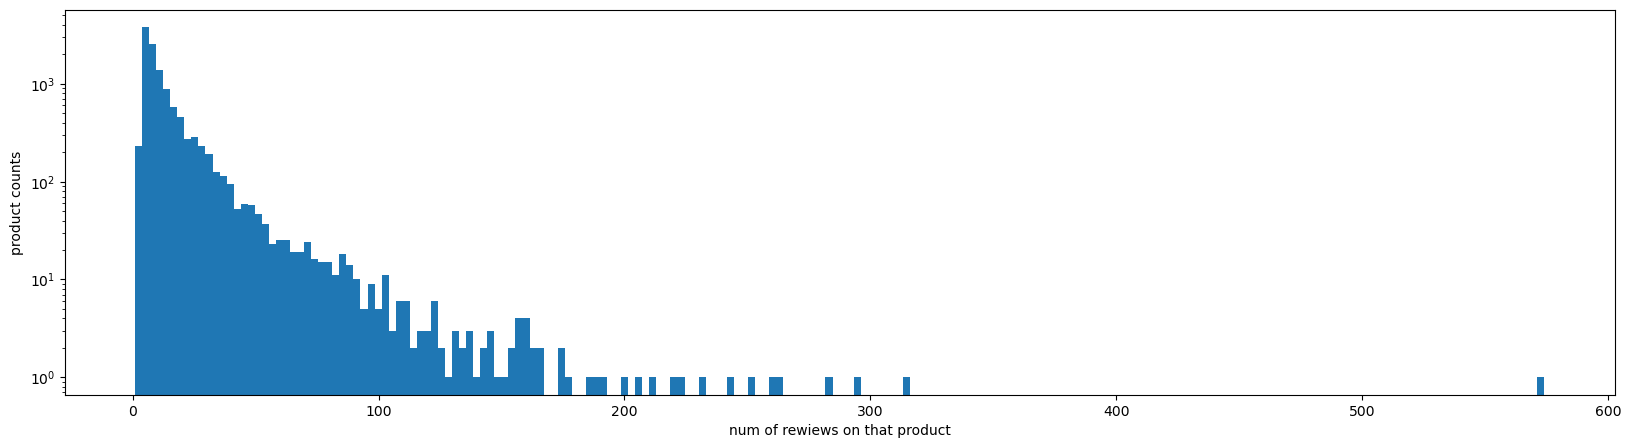

In [8]:
print("reviews product-counts")
print(reviews_per_asin.value_counts())

ax = reviews_per_asin.hist(log=True,grid=False,bins=200,figsize=(20,5))
ax.set_xlabel("num of rewiews on that product")
ax.set_ylabel("product counts")

Distribution of reviews per user

In [9]:
reviews_per_user = full_df.reviewerID.value_counts()
reviews_per_user

A3W4D8XOGLWUN5    791
A2H3JURQZOHVMB    314
A36EDWL4F3AASU    223
A165P3MOJV3OVZ    219
AVKHYC2D7MD56     214
                 ... 
A2VWLNEBMW4ITQ      2
A2M4D98UYXMUZE      2
A518S7KT78N51       2
A25HR6FTWBQ2NZ      1
A70WPHE33U5B        1
Name: reviewerID, Length: 16566, dtype: int64

reviews user-counts
5      4559
6      2798
7      1927
8      1288
9       974
       ... 
101       1
102       1
314       1
106       1
791       1
Name: reviewerID, Length: 125, dtype: int64


Text(0, 0.5, 'user counts')

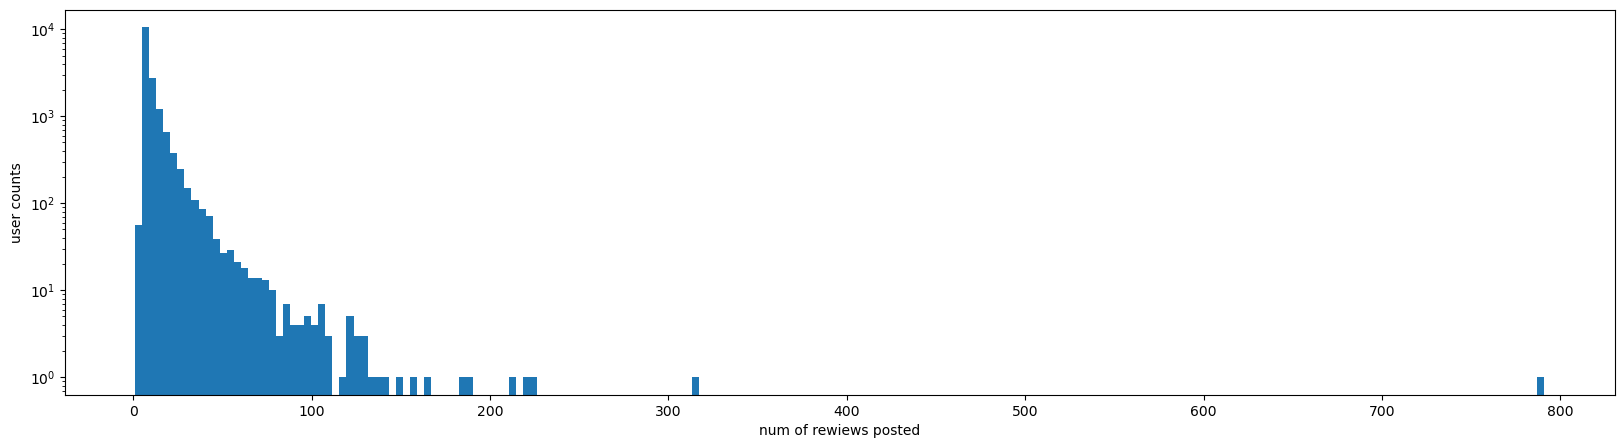

In [10]:
print("reviews user-counts")
print(reviews_per_user.value_counts())

ax = reviews_per_user.hist(log=True,grid=False,bins=200,figsize=(20,5))
ax.set_xlabel("num of rewiews posted")
ax.set_ylabel("user counts")


# 2. Text basic pre-processing

(Col:''Sentiment') based on the value of “rating of the product”:<br/> i. Ratings 4,5: Positive <br/>ii. Rating 3: Neutral <br/>iii. Ratings 1,2: Negative


In [11]:
full_df['Sentiment'] = np.where((full_df['overall'] > 3), 'Positive', 
                          np.where((full_df['overall'] < 3), 'Negative', 'Neutral'))
full_df.head(15)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Sentiment
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN,Positive
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN,Positive
2,5.0,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN,Positive
3,4.0,3,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN,Positive
4,5.0,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN,Positive
5,4.0,NaN,True,"11 19, 2015",A6JP9YYJCK3WO,5557706259,{'Format:': ' Audio CD'},Sylvia Arrowood,Enjoy Casting Crowns and their songs,Four Stars,1447891200,NaN,Positive
6,5.0,NaN,True,"06 6, 2015",A20Z0JD766DPG6,5557706259,{'Format:': ' Audio CD'},M Holley,Another very inspirational collection by a Ver...,Can't say enough. Great Christian music. God...,1433548800,NaN,Positive
7,5.0,NaN,False,"12 9, 2008",AXQ89O6YRT7AX,5557706259,{'Format:': ' MP3 Music'},PacificHype,"I love the song Slow Fade by Casting Crowns, e...",DEFINITELY DESERVES PERFECT STARS!!!!,1228780800,NaN,Positive
8,5.0,NaN,False,"10 7, 2008",A1M379MK8MKGUF,5557706259,{'Format:': ' MP3 Music'},Sergio,This is an awesome album from the amazing Chri...,Can't go wrong with Casting Crowns,1223337600,NaN,Positive
9,5.0,NaN,False,"09 3, 2008",AA762OWLWCPQ2,5557706259,{'Format:': ' Audio CD'},Daniel T. Hughes,I can't believe I haven't written a review for...,"Great music, but even better if you see them l...",1220400000,NaN,Positive


In [12]:
full_df['Sentiment'].value_counts() 

Positive    158985
Neutral       6792
Negative      4004
Name: Sentiment, dtype: int64

## columns selection

In [13]:
full_df['verified'].value_counts()

True     148944
False     20837
Name: verified, dtype: int64

In [66]:
#joining the two columns of review and summary of the reviews
cols = ['reviewText','summary']
full_df['NewReview'] = full_df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
full_df['NewReview'] = full_df['NewReview'].astype(str)



Shape of the dataset: (169781, 14)


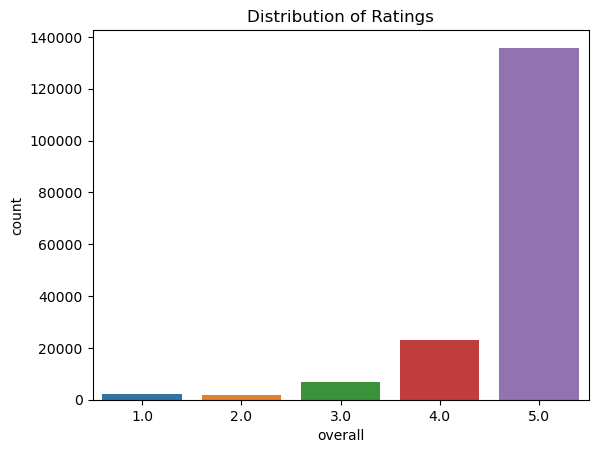

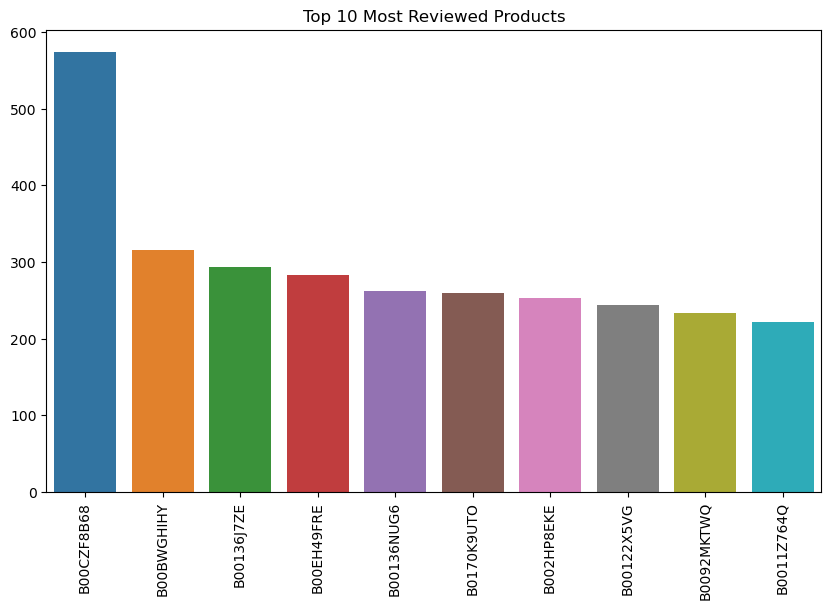

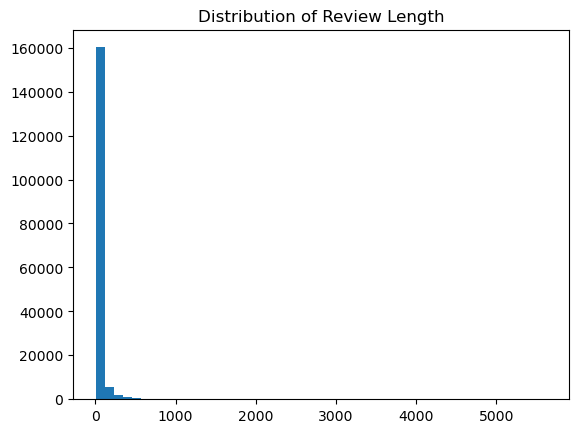

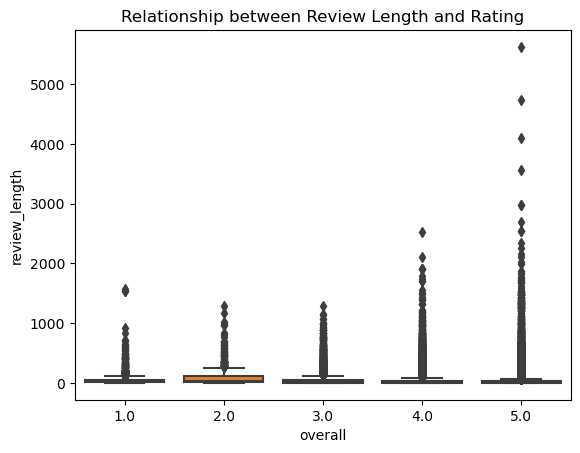

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check the shape of the dataset
print("Shape of the dataset:", full_df.shape)

# Check the distribution of ratings
sns.countplot(x='overall', data=full_df)
plt.title("Distribution of Ratings")
plt.show()

# Check the top 10 most reviewed products
top_products = full_df['asin'].value_counts().nlargest(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.index, y=top_products.values)
plt.title("Top 10 Most Reviewed Products")
plt.xticks(rotation=90)
plt.show()

# Check the length of reviews
full_df['review_length'] = full_df['NewReview'].apply(lambda x: len(x.split()))
plt.hist(full_df['review_length'], bins=50)
plt.title("Distribution of Review Length")
plt.show()

# Check the relationship between review length and rating
sns.boxplot(x='overall', y='review_length', data=full_df)
plt.title("Relationship between Review Length and Rating")
plt.show()

In [15]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         169781 non-null  float64
 1   vote            7611 non-null    object 
 2   verified        169781 non-null  bool   
 3   reviewTime      169781 non-null  object 
 4   reviewerID      169781 non-null  object 
 5   asin            169781 non-null  object 
 6   style           157989 non-null  object 
 7   reviewerName    169776 non-null  object 
 8   reviewText      169623 non-null  object 
 9   summary         169745 non-null  object 
 10  unixReviewTime  169781 non-null  int64  
 11  image           182 non-null     object 
 12  Sentiment       169781 non-null  object 
 13  NewReview       169781 non-null  object 
dtypes: bool(1), float64(1), int64(1), object(11)
memory usage: 17.0+ MB


In [16]:
full_df.head(2)

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image,Sentiment,NewReview
0,5.0,3,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN,Positive,"This is awesome to listen to, A must-have for ..."
1,5.0,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN,Positive,bien_Five Stars


In [56]:
#droppin unneccessary columns
music_review_df = full_df.drop(columns=['vote','image','reviewTime','style','reviewerName','unixReviewTime','reviewText','summary'])

In [57]:
music_review_df.head(2)

,overall,verified,reviewerID,asin,Sentiment,NewReview
0,5.0,True,A2TYZ821XXK2YZ,3426958910,Positive,"This is awesome to listen to, A must-have for ..."
1,5.0,True,A3OFSREZADFUDY,3426958910,Positive,bien_Five Stars


In [19]:
music_review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169781 entries, 0 to 169780
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   overall    169781 non-null  float64
 1   verified   169781 non-null  bool   
 2   asin       169781 non-null  object 
 3   Sentiment  169781 non-null  object 
 4   NewReview  169781 non-null  object 
dtypes: bool(1), float64(1), object(3)
memory usage: 5.3+ MB


## sampling 

In [20]:
#Getting the reviews from the dataset
sample_df=music_review_df.sample(n = 1000)
reviews = [str(review) for review in sample_df.NewReview.values]

In [21]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 163145 to 5571
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   overall    1000 non-null   float64
 1   verified   1000 non-null   bool   
 2   asin       1000 non-null   object 
 3   Sentiment  1000 non-null   object 
 4   NewReview  1000 non-null   object 
dtypes: bool(1), float64(1), object(3)
memory usage: 40.0+ KB


In [22]:
# average length
print('- average review length (words): ', len(re.findall(r'\w+', ' '.join(sample_df)))/len(sample_df))

- average review length (words):  0.005


# 3. Text representation (approaches in course module 2)

## Tokenisation, Lemmatization, Stemming, pos, entities

In [63]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

# Convert text to lowercase
sample_df['NewReview'] = sample_df['NewReview'].str.lower()

# Remove URLs
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: re.sub(r'http\S+', '', x))

# Remove HTML tags
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: re.sub(r'<.*?>', '', x))

# Remove punctuation
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Tokenize the text
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: word_tokenize(x))

# Remove stopwords and perform stemming
stop_words = set(stopwords.words('english'))
porter = PorterStemmer()

sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: [porter.stem(word) for word in x if word not in stop_words])

# Join the stemmed words back into a single string
sample_df['NewReview'] = sample_df['NewReview'].apply(lambda x: ' '.join(x))


In [61]:
sample_df['NewReview']

0                           wanted arrived timefour star
1                                     thank youfour star
2                                       love itfive star
3      currently one goto recording meditation breath...
4      gary doesnt disappoint number 1 makinggreat li...
                             ...                        
995            fast shipment product advertisedfive star
996       best rendition song ive ever heardworth buying
997    john fahey one best youve never heard give lis...
998                                  great songfive star
999                               favorite songfive star
Name: NewReview, Length: 1000, dtype: object

In [23]:
#Tokenisation
#tokens = [[token.text for token in nlp(sentence)] for sentence in sample_df]

#Lemmatization
#lemmas = [[token.lemma_ if token.lemma_ != "-PRON-" else token.lower_ for token in nlp(sentence)] for sentence in sample_df]

#Stemming
#stems = [[stemmer.stem(token) for token in sentence] for sentence in tokens]

#Getting pos
#pos = [nltk.pos_tag(token) for token in tokens]

#Getting entities
#entities = [[[ent.text, ent.label_] for ent in nlp(sentence).ents] for sentence in sample_df] 

In [26]:
#Most common people
#people = [person[0] for person in [item for sublist in entities for item in sublist if item[1]=='PERSON']]
#print('5 most common people: ', Counter(people).most_common(10))

#Most common music
#music = [person[0] for person in [item for sublist in entities for item in sublist if item[1]=='WORK_OF_ART']]
#print('5 most common work of art: ', Counter(music).most_common(10))

In [25]:
#Taking the stems or the lemmas 
ptext = [' '.join(word) for word in lemmas]

#Converting to lowercase
ptext = [review.lower() for review in ptext]

#Removing numbers
ptext = [re.sub(r'\d+', '', review) for review in ptext]

#Removing punctuation
ptext = [re.sub(r'[^\w\s]',' ',review) for review in ptext]
ptext = [re.sub(' +', ' ', review) for review in ptext]
ptext = [re.sub('_', '', review) for review in ptext]

#Removing leading and trailing whitespaces
ptext = [review.strip() for review in ptext]

#Removing stopwords
ptext = [' '.join([word for word in review.split() if word not in stop_words]) for review in ptext]

In [27]:
frame = {'Original': [sample_df], 
        'After Proprocessing': [ptext]}

pd.DataFrame.from_dict(frame)


,Original,After Proprocessing
0,overall verified asin Sentimen...,"[overall, verify, asin, sentiment, newreview]"


In [28]:
df_2345 = pd.DataFrame.from_records([{ 'Original': sample_df, 
        'After Proprocessing': ptext }])
df_2345

,Original,After Proprocessing
0,overall verified asin Sentimen...,"[overall, verify, asin, sentiment, newreview]"


In [29]:
#Number of words
print('Number of words:')

bef = len(re.findall(r'\w+', ' '.join(sample_df)))
aft = len(re.findall(r'\w+', ' '.join(ptext)))

print('- Before preprocessing: ', bef )
print('- After preprocessing: ', aft )
print()

#Average review length
print('Average review length:')

bef_a = bef/10000
aft_a = aft/10000

print('- Before preprocessing: ', bef_a )
print('- After preprocessing: ', aft_a )
print()

#Punctuation
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
punct_b = 0
for i in sample_df:
    punct_b += count(i,set(string.punctuation))
punct_a = 0
for i in ptext:
    punct_a += count(i,set(string.punctuation))
    
print('Number of punctuation character:')
print('- Before preprocessing: ', punct_b)
print('- After preprocessing: ', punct_a)
print()


Number of words:
- Before preprocessing:  5
- After preprocessing:  5

Average review length:
- Before preprocessing:  0.0005
- After preprocessing:  0.0005

Number of punctuation character:
- Before preprocessing:  0
- After preprocessing:  0



# 4. Modeling 

## VADR sentiment

In [30]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [32]:
#!pip install --upgrade vaderSentiment
#nltk.download('sentiwordnet')
#nltk.download('omw-1.4')

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\98936\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\98936\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [34]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def sentiment_scores(sentence):
 
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence) 
 
    # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0 :
        result = 'Positive'
 
    elif sentiment_dict['compound'] < - 0.07 :
        result = 'negative'
 
    else :
        result = 'Neurtral'
    return result, sentiment_dict

In [ ]:
sample_df.reset_index(inplace=True)

In [54]:
sample_df['SentimentScores'] = sample_df['NewReview'].apply(lambda x: sentiment_scores(x))
sample_df[['PredictedSentiment','SentimentDict']] = sample_df['SentimentScores'].apply(lambda x: pd.Series([x[0], x[1]]))

Overall sentiment dictionary is :  {'neg': 0.042, 'neu': 0.724, 'pos': 0.233, 'compound': 1.0}
sentence was rated as  4.2 % Negative
sentence was rated as  72.39999999999999 % Neutral
sentence was rated as  23.3 % Positive
Sentence Overall Rated As Positive


In [38]:
sample_df['SentimentScores'][10] , sample_df['Sentiment'][10], sample_df['NewReview'][10]

In [ ]:
# Define a function to compute the accuracy
def compute_accuracy(row):
    if row['PredictedSentiment'] == row['Sentiment']:
        return 1
    else:
        return 0

# Apply the function to each row and save the results to a new column
sample_df['accuracy'] = sample_df.apply(compute_accuracy, axis=1)

# Compute the overall accuracy
accuracy = sample_df['accuracy'].sum() / len(sample_df)
print(f"Overall accuracy: {accuracy}")

## Text blob

In [42]:
from textblob import TextBlob

In [43]:
wiki = TextBlob(sample_df['NewReview'][0])

In [44]:
import nltk
nltk.download('punkt')
nltk.download('brown')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\98936\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\98936\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\brown.zip.


True

In [45]:
#Parts of Speech
wiki.tags

[('Just', 'RB'),
 ('what', 'WP'),
 ('I', 'PRP'),
 ('wanted', 'VBD'),
 ('arrived', 'VBN'),
 ('on', 'IN'),
 ('time._Four', 'NN'),
 ('Stars', 'NNS')]

In [46]:
wiki.noun_phrases

WordList([])

In [47]:
wiki.sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [48]:
wiki.words

WordList(['Just', 'what', 'I', 'wanted', 'arrived', 'on', 'time._Four', 'Stars'])

In [49]:
df['sentiment'] = sample_df['NewReview'].apply(lambda tweet: TextBlob(tweet).sentiment)

In [50]:
df_reviews = df

In [51]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

df_reviews['sentiment'] = sample_df['NewReview'].apply(sentiment_calc)

In [52]:
df_reviews

,data,sentiment
0,"{'overall': 5.0, 'vote': '3', 'verified': True...","(0.0, 0.0)"
1,"{'overall': 5.0, 'verified': True, 'reviewTime...","(0.0, 0.0)"
2,"{'overall': 5.0, 'verified': True, 'reviewTime...","(0.5, 0.6)"
3,"{'overall': 4.0, 'vote': '3', 'verified': Fals...","(0.24138888888888893, 0.5711111111111111)"
4,"{'overall': 5.0, 'verified': True, 'reviewTime...","(0.0, 0.0)"
...,...,...
169776,"{'overall': 5.0, 'verified': True, 'reviewTime...",NaN
169777,"{'overall': 5.0, 'verified': True, 'reviewTime...",NaN
169778,"{'overall': 5.0, 'verified': True, 'reviewTime...",NaN
169779,"{'overall': 5.0, 'verified': True, 'reviewTime...",NaN


## Word Cloud

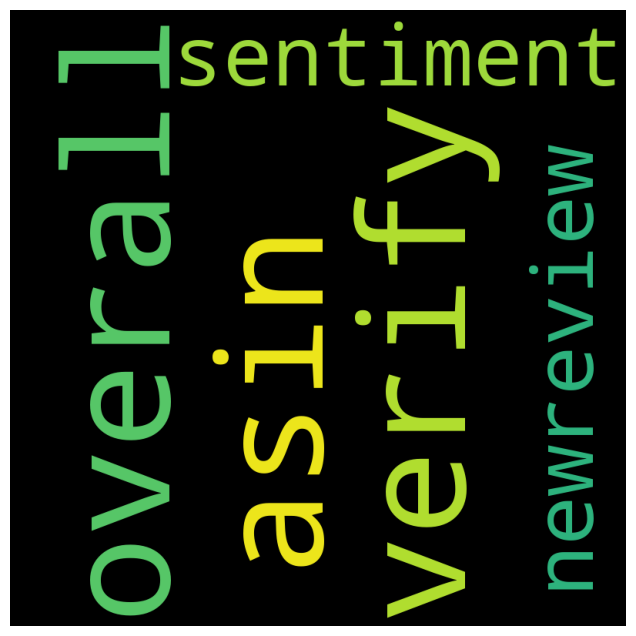

In [53]:
#Code take from GFG to generate Word Cloud

comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in ptext:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "

#Generate word cloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
#Plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
 
plt.show()